In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from warnings import filterwarnings
from tqdm import tqdm
import statsmodels.api as sm
filterwarnings('ignore')

# The Data Class

In [76]:
class DengueData:
    def __init__(self, impute=None, test_setsz=.2):

        features = pd.read_csv('../Data/dengue_features_train.csv')
        features.index = pd.DatetimeIndex(features.week_start_date)#.to_period("w")
        features.index = pd.MultiIndex.from_tuples(list(zip(*[features.city, features.index])), names=['city', 'week_start_date'])
        self.features = features[features.columns[4:]]
        self.labels = pd.read_csv('../Data/dengue_labels_train.csv', index_col=[0, 1, 2])
        self.labels.index = features.index
        self.n_features, self.n_samples = self.features.shape
        self.feat_train, self.labels_train, self.feat_test, self.labels_test = [None] * 4
        if impute is not None:
            self.impute_missing(method=impute)

    def impute_missing(self, method, add_indicator=False):
        '''
        Method for imputting missing data

        :param add_indicator:
        :param method: str; how to impute missing values
            pad / ffill: propagate last valid observation forward to next valid
            backfill / bfill: use next valid observation to fill gap.
            mean: fill with the mean value of the feature
            median: fill with median value of the feature
            KNN: optimized K-nearest neighbors
        :return:
        '''
        if add_indicator:
                self.features = self.features.join(self.features.isna().astype(float), rsuffix='_miss')
        if method in ['backfill', 'bfill', 'pad', 'ffill']:
            self.features.fillna(method=method, inplace=True)
        elif method == 'mean':
            self.features.fillna(value=self.features.mean(axis=0), inplace=True)
        elif method == 'median':
            self.features.fillna(value=self.features.median(axis=0), inplace=True)
        elif method == 'linear':
            self.features.interpolate(method='linear', axis=0, inplace=True)
        else:
            rmse = lambda actual, yhat: np.sqrt(mean_squared_error(actual, yhat))
            errors = {'K':[], 'RMSE':[]}
            for k in range(1, 20, 2):
                imputer = KNNImputer(n_neighbors=k, weights='distance')
                imputed = pd.DataFrame(imputer.fit_transform(self.features))
                feat_train, labels_train, feat_test, labels_test = self.split_train_test(x=imputed)
                model = RandomForestRegressor()
                model.fit(feat_train, labels_train.to_numpy().ravel())
                preds = model.predict(feat_test)
                error = rmse(labels_test, preds)
                errors['K'].append(k)
                errors['RMSE'].append(error)
            df_k = pd.DataFrame(errors)
            k = int(df_k.loc[df_k['RMSE'].idxmin()]['K'])
            imputer = KNNImputer(n_neighbors=k, weights='distance')
            self.features =  pd.DataFrame(imputer.fit_transform(self.features), columns = list(self.features.columns), index=self.features.index)

    def split_train_test(self, inplace=False, append_labels=False, intercept=False, x=None, y=None, city=None,  test_setsz=.2):

        if x is None:
            x = self.features
        if y is None:
            y = self.labels
        if intercept:
            x.insert(loc=0, column="Intercept", value=1)

        if city is not None:
            x = x.loc[city]
            y = y.loc[city]

        feat_train = x.iloc[:int(np.floor(len(x) * (1 - test_setsz)))]
        feat_test = x.iloc[:int(np.floor(len(x) * test_setsz))]

        labels_train = y.iloc[:int(np.floor(len(y) * (1 - test_setsz)))]
        labels_test = y.iloc[:int(np.floor(len(y) * test_setsz))]

        if append_labels:
            feat_train['total_cases'] = labels_train.total_cases.values
            feat_test['total_cases'] = labels_test.total_cases.values

        if inplace:
            self.feat_train, self.labels_train, self.feat_test, self.labels_test = [feat_train, labels_train, feat_test, labels_test]
            return
        else:
            return feat_train, labels_train, feat_test, labels_test

    def plot_case_dist(self):
        sns.displot(x='total_cases', col='city', data=self.labels);
        pass

    def plot_cases(self):
        sns.relplot(x=self.features.index.get_level_values(1), y=self.labels.total_cases, col=self.features.index.get_level_values(0), kind='line');

    def principle_components(self, n_pc, city=None, plotting=True):
        if city is not None:
            xx = self.features.loc[city]
        else:
            xx = self.features
        X_scaled = StandardScaler().fit_transform(xx)


        pc_list = ["PC"+str(i) for i in list(range(1, n_pc+1))]
        # Decompose
        pca = PCA(n_components=n_pc)
        self.feat_pc = pd.DataFrame(data=pca.fit_transform(X_scaled), columns=pc_list, index=xx.index)
        #finalDf = pd.concat([self.feat_pc, pd.Series(Y.total_cases.values, name='total_cases')], axis=1)
        skree_df = pd.DataFrame({'unexplained variance': pca.explained_variance_ratio_, 'PC':pc_list})
        total_var_exp = np.cumsum(pca.explained_variance_ratio_)

        # Attribute loadings onto PCs
        loadings = pca.components_
        #num_pc = pca.n_features_
        loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, abs(loadings))))
        loadings_df['variable'] = self.features.columns
        loadings_df.set_index('variable', inplace=True)
        loadings_df.sort_values(pc_list, ascending=False, inplace=True)
        if plotting:
            f, ax = plt.subplots(figsize=(20, 7), ncols=2)
            sns.pointplot(x='PC', y="unexplained variance", data=skree_df, color="c", ax=ax[1])
            sns.heatmap(loadings_df, ax=ax[0])
            ax[0].set_title("Loading")
            ax[1].set_title("Skree - Unexplained Variance")


In [88]:
#TODO: Add methods to interpolate based on time, or polynomial e.g. quadratic, cubic, etc.
dat = DengueData()
X =dat.features
idx = X.index
X.reset_index(drop=True, inplace=True)
X.index=idx.get_level_values('week_start_date')
X.interpolate(method='time', axis=0, inplace=True)
X.index = idx
X

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city week_start_date                                           
sj   1990-04-30       0.122600  0.103725  0.198483  0.177617   
     1990-05-07       0.169900  0.142175  0.162357  0.155486   
     1990-05-14       0.032250  0.172967  0.157200  0.170843   
     1990-05-21       0.128633  0.245067  0.227557  0.235886   
     1990-05-28       0.196200  0.262200  0.251200  0.247340   
...                        ...       ...       ...       ...   
iq   2010-05-28       0.342750  0.318900  0.256343  0.292514   
     2010-06-04       0.160157  0.160371  0.136043  0.225657   
     2010-06-11       0.247057  0.146057  0.250357  0.233714   
     2010-06-18       0.333914  0.245771  0.278886  0.325486   
     2010-06-25       0.298186  0.232971  0.274214  0.315757   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city week_start_date                                                
sj   1990-04-30                      12.42             297.572857   
     1990-05-07                      22.82             298.211429   
     1990-05-14                      34.54             298.781429   
     1990-05-21                      15.36             298.987143   
     1990-05-28                       7.52             299.518571   
...                                    ...                    ...   
iq   2010-05-28                      55.30             299.334286   
     2010-06-04                      86.47             298.330000   
     2010-06-11                      58.94             296.598571   
     2010-06-18                      59.67             296.345714   
     2010-06-25                      63.22             298.097143   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city week_start_date                                                       
sj   1990-04-30                  297.742857                   292.414286   
     1990-05-07                  298.442857                   293.951429   
     1990-05-14                  298.878571                   295.434286   
     1990-05-21                  299.228571                   295.310000   
     1990-05-28                  299.664286                   295.821429   
...                                     ...                          ...   
iq   2010-05-28                  300.771429                   296.825714   
     2010-06-04                  299.392857                   296.452857   
     2010-06-11                  297.592857                   295.501429   
     2010-06-18                  297.521429                   295.324286   
     2010-06-25                  299.835714                   295.807143   

                      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
city week_start_date                                                         
sj   1990-04-30                           299.8                      295.9   
     1990-05-07                           300.9                      296.4   
     1990-05-14                           300.5                      297.3   
     1990-05-21                           301.4                      297.0   
     1990-05-28                           301.9                      297.5   
...                                         ...                        ...   
iq   2010-05-28                           309.7                      294.5   
     2010-06-04                           308.5                      291.9   
     2010-06-11                           305.5                      292.4   
     2010-06-18                           306.1                      291.9   
     2010-06-25                           307.8                      292.3   

                      reanalysis_precip_amt_kg_per_m2  \
city week_start_date                                    
sj   1990-04-30                                 32.00   
     1990-05-07                                 17.94   
     1990-05-14                                 26.10   
   

In [74]:
dat.impute_missing(method='ffill')
dat.features

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city week_start_date                                           
sj   1990-04-30       0.122600  0.103725  0.198483  0.177617   
     1990-05-07       0.169900  0.142175  0.162357  0.155486   
     1990-05-14       0.032250  0.172967  0.157200  0.170843   
     1990-05-21       0.128633  0.245067  0.227557  0.235886   
     1990-05-28       0.196200  0.262200  0.251200  0.247340   
...                        ...       ...       ...       ...   
iq   2010-05-28       0.342750  0.318900  0.256343  0.292514   
     2010-06-04       0.160157  0.160371  0.136043  0.225657   
     2010-06-11       0.247057  0.146057  0.250357  0.233714   
     2010-06-18       0.333914  0.245771  0.278886  0.325486   
     2010-06-25       0.298186  0.232971  0.274214  0.315757   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city week_start_date                                                
sj   1990-04-30                      12.42             297.572857   
     1990-05-07                      22.82             298.211429   
     1990-05-14                      34.54             298.781429   
     1990-05-21                      15.36             298.987143   
     1990-05-28                       7.52             299.518571   
...                                    ...                    ...   
iq   2010-05-28                      55.30             299.334286   
     2010-06-04                      86.47             298.330000   
     2010-06-11                      58.94             296.598571   
     2010-06-18                      59.67             296.345714   
     2010-06-25                      63.22             298.097143   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city week_start_date                                                       
sj   1990-04-30                  297.742857                   292.414286   
     1990-05-07                  298.442857                   293.951429   
     1990-05-14                  298.878571                   295.434286   
     1990-05-21                  299.228571                   295.310000   
     1990-05-28                  299.664286                   295.821429   
...                                     ...                          ...   
iq   2010-05-28                  300.771429                   296.825714   
     2010-06-04                  299.392857                   296.452857   
     2010-06-11                  297.592857                   295.501429   
     2010-06-18                  297.521429                   295.324286   
     2010-06-25                  299.835714                   295.807143   

                      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
city week_start_date                                                         
sj   1990-04-30                           299.8                      295.9   
     1990-05-07                           300.9                      296.4   
     1990-05-14                           300.5                      297.3   
     1990-05-21                           301.4                      297.0   
     1990-05-28                           301.9                      297.5   
...                                         ...                        ...   
iq   2010-05-28                           309.7                      294.5   
     2010-06-04                           308.5                      291.9   
     2010-06-11                           305.5                      292.4   
     2010-06-18                           306.1                      291.9   
     2010-06-25                           307.8                      292.3   

                      reanalysis_precip_amt_kg_per_m2  \
city week_start_date                                    
sj   1990-04-30                                 32.00   
     1990-05-07                                 17.94   
     1990-05-14                                 26.10   
   

In [75]:
dat = DengueData(impute='linear')
ft, lt, fy, ly = dat.split_train_test(city='sj', intercept=True)
ft

,Intercept,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,1,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,1,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,1,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,1,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-08-12,1,0.037400,0.108400,0.125300,0.177414,20.92,300.995714,301.200000,296.400000,302.9,...,14.10,76.171429,20.92,17.818571,2.657143,28.942857,7.228571,33.9,24.4,10.5
2004-08-19,1,-0.016400,-0.021875,0.181600,0.170600,37.30,300.794286,300.850000,297.268571,302.6,...,44.40,81.264286,37.30,18.774286,2.585714,29.000000,6.314286,32.2,24.4,28.3
2004-08-26,1,0.099600,0.063300,0.100657,0.109429,20.30,300.912857,301.050000,297.054286,302.6,...,13.50,79.684286,20.30,18.531429,2.642857,29.057143,6.485714,33.3,25.0,20.6


# Negative Binomial
## with all features

In [78]:

for mtd in ['mean', 'median','linear', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc in ['sj', 'iq']:
        dat = DengueData(impute=mtd)
        feat_train, labels_train, feat_test, labels_test = dat.split_train_test(city=cc, intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in feat_train.columns])
        nb_train_result = sm.GLM(endog=labels_train , exog=feat_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(feat_test).predicted_mean
        errs.append(abs(labels_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')



imput method: mean, error: 19.044282658935586
imput method: median, error: 18.690662151615673
imput method: linear, error: 17.71938222450332
imput method: bfill, error: 18.31706072520119
imput method: ffill, error: 17.186355125778164
imput method: KNN, error: 18.856585747265736


## with Principle Componnents

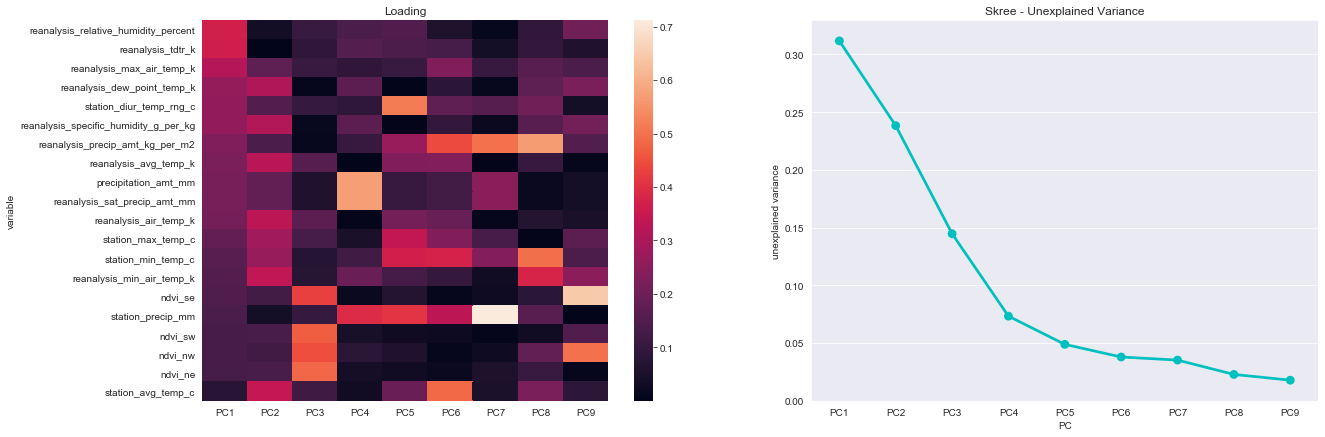

In [79]:
dat = DengueData(impute='ffill')
dat.principle_components(n_pc=9, city='iq')

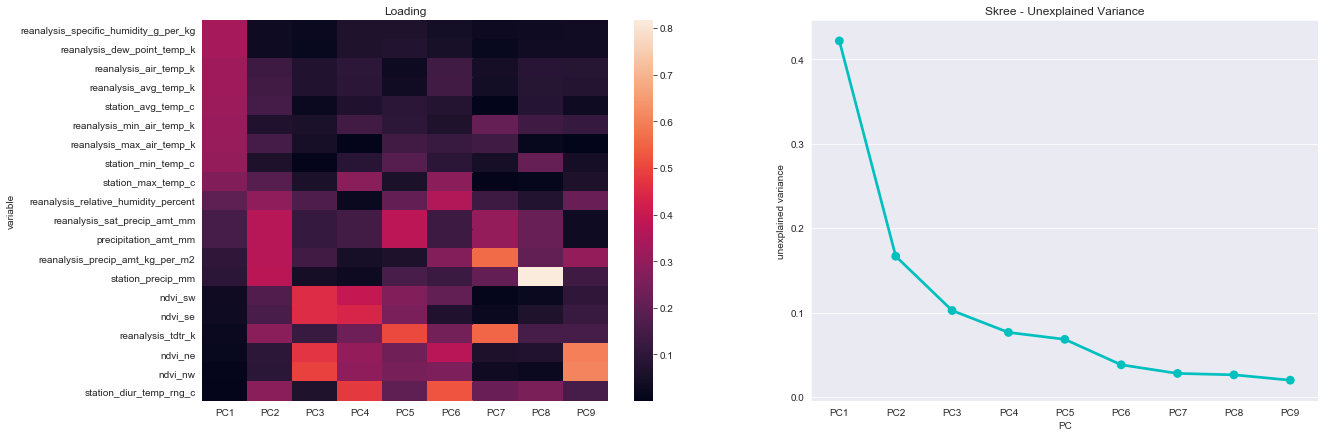

In [80]:
dat = DengueData(impute='ffill')
dat.principle_components(n_pc=9, city='sj')

In [18]:
for mtd in ['mean', 'median','linear', 'bfill', 'ffill', 'KNN']:
    errs = []
    for cc, npc in zip(['sj', 'iq'], [4, 5]):
        dat = DengueData(impute=mtd)
        dat.principle_components(n_pc=npc, city=cc, plotting=False)
        pc_x_train, pc_y_train, pc_x_test, pc_y_test = dat.split_train_test(x=dat.feat_pc, y=dat.labels.loc[cc], intercept=True)
        formula = 'total_cases ~ + 1 '+" ".join(['+ '+v for v in pc_x_train.columns])
        nb_train_result = sm.GLM(endog=pc_y_train , exog=pc_x_train, family=sm.families.NegativeBinomial(alpha=1)).fit()
        test_preds = nb_train_result.get_prediction(pc_x_test).predicted_mean
        errs.append(abs(pc_y_test.total_cases - test_preds))
    print(f'imput method: {mtd}, error: {errs[0].append(errs[1]).mean()}')


imput method: mean, error: 17.902582800307933
imput method: median, error: 17.781942484962396
imput method: bfill, error: 18.15099103592254
imput method: ffill, error: 17.193141938398902
imput method: KNN, error: 17.358981109013705


# AR models

In [ ]:
dat = DengueData(impute='ffill')

x_train, y_train, x_test, y_test = dat.split_train_test(city='sj', intercept=True)


## Testing for stationarity

In [44]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

result = adfuller(y_train['total_cases'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )
if result[1] <= 0.05:
    print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
else:
    print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

ADF Test Statistic : -4.914390459100147
p-value : 3.269348022161414e-05
#Lags Used : 12
Number of Observations Used : 735
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


In [51]:
errs = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True)
    for df in [x_train, y_train, x_test, y_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,  order=(1,0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.predict(start=y_test.index[0], end=y_test.index[-1])
    errs.append(abs(y_pred.values - y_test.total_cases.values))

print(f'ARMA method error: {np.concatenate(errs).mean()}')


ARMA method error: 10.917481722101632


In [105]:
preds = []
for cc in ['sj', 'iq']:
    dat = DengueData(impute='ffill')
    #x_train = dat.features
    #y_train = dat.labels
    x_train, y_train, x_test, y_test = dat.split_train_test(city=cc, intercept=True, test_setsz=0)

    x_test = pd.read_csv('../Data/dengue_features_test.csv', index_col=[0, 1, 2])

    x_test = x_test.loc[cc]

    for df in [x_train, y_train, x_test]:
        df.reset_index(inplace=True)
        df.index = pd.DatetimeIndex(df.week_start_date).to_period('W')
        df.drop('week_start_date', inplace=True, axis=1)
    wk = x_test[['year', 'weekofyear']]
    x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)
    x_test.fillna(method='ffill', inplace=True)
    x_test.insert(loc=0, column="Intercept", value=1)

    ARMAmodel = sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train,  order=(1,0, 1))
    res = ARMAmodel.fit()
    # generating predictions
    y_pred = res.predict(start=x_test.index[0], end=x_test.index[-1], exog=x_test)
    preds.append(y_pred)

ValueError: Provided exogenous values are not of the appropriate shape. Required (264, 21), got (260, 21).

In [106]:
x_train

,Intercept,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30/1990-05-06,1,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07/1990-05-13,1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14/1990-05-20,1,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21/1990-05-27,1,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28/1990-06-03,1,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-24/2008-03-30,1,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
2008-03-31/2008-04-06,1,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
2008-04-07/2008-04-13,1,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7


In [96]:
wk = x_test[['year', 'weekofyear']]
x_test.drop(['year', 'weekofyear'], axis=1, inplace=True)


In [98]:
x_test.fillna(method='ffill', inplace=True)
x_test

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
2008-04-28/2008-05-04,-0.0189,-0.0189,0.102729,0.0912,78.6,298.492857,298.55,294.527143,301.1,296.4,25.37,78.781429,78.6,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-05/2008-05-11,-0.018,-0.0124,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.23,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-12/2008-05-18,-0.0015,ffill,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.27,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-19/2008-05-25,ffill,-0.019867,0.124329,0.125686,0.0,299.69,299.728571,294.402857,303.0,296.9,2.2,73.015714,0.0,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-26/2008-06-01,0.0568,0.039833,0.062267,0.075914,0.76,299.78,299.671429,294.76,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-25/2013-03-31,-0.0874,-0.016183,0.156343,0.105186,30.34,298.67,298.885714,294.675714,301.3,296.4,2.55,78.78,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-01/2013-04-07,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,64.3,81.65,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-08/2013-04-14,-0.1176,-0.0082,0.1927,0.170429,0.0,299.057143,299.328571,294.948571,301.5,297.5,0.7,78.285714,0.0,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [21]:
'''import requests
from io import BytesIO

# Dataset
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
#Set the frequency
data.index.freq="QS-OCT"
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())'''

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -172.610
Date:                Thu, 21 Jul 2022   AIC                            353.221
Time:                        16:23:16   BIC                            364.502
Sample:                    01-01-1960   HQIC                           357.804
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0438      0.427      0.103      0.918      -0.794       0.882
ar.L1          0.9994      0.006    172.091      0.000       0.988       1.011
ma.L1          0.5628      0.072      7.848      0.0

In [87]:
a = res.get_prediction()

In [20]:
data

,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515
...,...,...,...
1989-10-01,109.400002,1989-10-01,4.695011
1990-01-01,111.000000,1990-01-01,4.709530
1990-04-01,110.800003,1990-04-01,4.707727


In [43]:
labels_train

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6
...,...
2004-08-12,14
2004-08-19,14
2004-08-26,7
